In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
import pandas as pd
from global_model_periodic import LearnedSimulator_periodic
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high')


In [3]:
def compute_polygon_area_and_perimeter(polygon):
    polygon = np.array(polygon,dtype = np.float32)
    # Aire (Green's theorem)
    x = polygon[:, 0]
    y = polygon[:, 1]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    # Périmètre
    perimeter = np.sum(np.linalg.norm(np.roll(polygon, -1, axis=0) - polygon, axis=1))
    return area, perimeter

def vornoi_area_and_perimeter(vor,target_indices):
    """
    Computes the area and perimeter of Voronoi regions.

    Args:
        vor (scipy.spatial.Voronoi): Voronoi diagram object.

    Returns:
        tuple: Areas and perimeters of the Voronoi regions.
    """

    areas = []
    perimeters = []

    for idx in target_indices:
        region_index = vor.point_region[idx]
        region = vor.regions[region_index]
        if -1 in region or len(region) == 0:
            areas.append(np.float32(1e-10))
            perimeters.append(np.float32(1e-10))
            continue
        polygon = [vor.vertices[i] for i in region]
        area, perimeter = compute_polygon_area_and_perimeter(polygon)
        areas.append(np.float32(area))
        perimeters.append(np.float32(perimeter)  )        
    return areas,perimeters

In [4]:
def loss_complete(acceleration, target):
    mse_loss = torch.nn.functional.mse_loss(acceleration, target)
    return mse_loss 

In [5]:
class TrajectoryDataset(Dataset):
    def __init__(self, csv_file_paths, step, seq_len=5, noise_std=0.0):
        self.samples = []
        self.seq_len = seq_len
        self.noise_std = noise_std

        for i in range(1,11):
            csvpath = csv_file_paths + str(i) + ".csv"
            df = pd.read_csv(
                csvpath,
                dtype={"x": np.float32, "y": np.float32, "step": np.int32, "site_index": np.int32}
            )
            

            df_grouped = df.groupby('step')
            clean_positions = []

            for step_id, data in df_grouped:
                if step_id < step:
                    data_sorted = data.sort_values('site_index')
                    np_data = data_sorted[['x', 'y']].to_numpy(dtype=np.float32)
                    pos = torch.from_numpy(np_data)
                    clean_positions.append(pos)

            for t in range(seq_len - 1, len(clean_positions)):
                input_seq = clean_positions[t - seq_len + 1: t + 1] 

                
                x_t2 = input_seq[-3]
                x_t1 = input_seq[-2]
                x_t = input_seq[-1]
                acc = x_t - 2*x_t1  + x_t2

                def noisy(x): 
                    return x + torch.randn_like(x) * self.noise_std if self.noise_std > 0 else x

                input_seq_noisy = torch.stack([noisy(x) for x in input_seq])
                self.samples.append((input_seq_noisy, acc))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [6]:
def generate_next_positions(model, device, vrai_pos,n_cells):
    model.eval()
    pos = vrai_pos.copy()
    x = torch.tensor(np.stack(pos, axis=1), dtype=torch.float32).to(device)
    next_position, acc = model(x,n_cells)
    for i in range(len(pos)-1):
        pos[i] = pos[i+1].copy()
    pos[-1] = next_position.cpu().detach().numpy()
    return pos,acc

In [7]:
def avg_test(model,device,csv_file,n_cells):
    loss = 0
    csvpath = csv_file + str(11) +".csv" 
    df = pd.read_csv(csvpath)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions)
        vrai_pos.append(positions)
    for step in steps_list[5:50]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
            vrai_pos[i] = vrai_pos[i+1].copy() 
        vrai_pos[-1] = positions.copy()
        loss+=loss_fn(acc,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells]*1e3, dtype=torch.float).to(device)).item()
    return loss/45
        

In [8]:
def train_gnn_optimized(model, csv_files, loss_fn, epochs=11, lr=1e-4, batch_size=32, seq_len=5, noise_std=0.0, device='cuda'):
    model = model.to(device)
    model = torch.compile(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler(device=device)
    n_cells = 10
    print("Loading dataset...")
    start = time.perf_counter()
    dataset = TrajectoryDataset(csv_files, step=200, seq_len=seq_len, noise_std=noise_std)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset loaded in {time.perf_counter() - start:.2f} seconds")
    
    model.train()
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_batches = 0
        for x_seq, acc in dataloader:
            x_seq = x_seq.to(device)
            acc = acc.to(device).squeeze(0)
            acc =acc[:n_cells]
            input_traj = x_seq.permute(0, 2, 1, 3).squeeze(0)
            optimizer.zero_grad()
            with autocast(device_type='cuda',enabled=False):
                output, pred_acc = model(input_traj,n_cells)
                loss = loss_fn(pred_acc, 1e3 * acc)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            total_loss += loss.item()
            total_batches += 1
        avg_loss = total_loss / total_batches if total_batches > 0 else 0
        

        if epoch % 5 == 0:
            model.eval()
            train_loss.append(avg_loss)
            print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.6f}")
            test_l = avg_test(model, device, csv_files,n_cells)
            test_loss.append(test_l)
            print(f"Test Loss: {test_l:.6f}")
            model.train()
            print(1e3*acc,pred_acc)
            path_prefix = "//home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_15Conv_256/"
            torch.save(model.state_dict(), path_prefix + f"model_{epoch}.pth")
            loss_df = pd.DataFrame({
                "epoch": list(range(len(train_loss))),
                "global_loss": train_loss,
                "test_loss": test_loss
            })
            loss_df.to_csv(path_prefix + f"loss_{epoch}.csv", index=False)

    return model, train_loss, test_loss


In [9]:
normalization_stats = {
    "velocity": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)},
    "acceleration": {"mean": torch.tensor([0.0, 0.0]).to(device), "std": torch.tensor([1e-3, 1e-3]).to(device)}
}

In [ ]:
model = LearnedSimulator_periodic(num_dimensions=2, normalization_stats=normalization_stats, device=device)
model.to(device)
trained_model, train_loss, test_loss = train_gnn_optimized(
    model=model,
    csv_files="/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_",
    loss_fn=loss_complete,
    epochs= 101,
    lr=1e-4,
    batch_size=1,
    seq_len=5,
    noise_std=0.001,
    device='cuda'
)


Loading dataset...
Dataset loaded in 0.97 seconds


  0%|          | 0/101 [00:00<?, ?it/s]W0708 14:08:23.710000 1368343 torch/_dynamo/convert_frame.py:964] [6/8] torch._dynamo hit config.recompile_limit (8)
W0708 14:08:23.710000 1368343 torch/_dynamo/convert_frame.py:964] [6/8]    function: 'compute_polygon_area_and_perimeter' (/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Model/global_model_periodic.py:34)
W0708 14:08:23.710000 1368343 torch/_dynamo/convert_frame.py:964] [6/8]    last reason: 6/2: len(polygon) == 5                                      
W0708 14:08:23.710000 1368343 torch/_dynamo/convert_frame.py:964] [6/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0708 14:08:23.710000 1368343 torch/_dynamo/convert_frame.py:964] [6/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


Epoch 1/101, Avg Loss: 0.002883


  1%|          | 1/101 [00:58<1:37:37, 58.57s/it]

Test Loss: 0.004378
tensor([[-0.1120,  0.0074],
        [-0.0113,  0.0443],
        [ 0.0078,  0.0208],
        [-0.0098, -0.0552],
        [ 0.0281,  0.0010],
        [ 0.0234, -0.0185],
        [-0.0157, -0.0157],
        [ 0.0117, -0.0031],
        [ 0.0145,  0.0225],
        [ 0.0632, -0.0035]], device='cuda:0') tensor([[ 4.5696e-03,  1.1511e-06],
        [-4.9593e-03,  5.9356e-04],
        [-1.1867e-02,  8.7927e-03],
        [-8.1608e-03,  3.9267e-03],
        [ 2.7654e-03,  2.4673e-03],
        [ 1.1288e-02, -4.8052e-03],
        [ 3.9511e-03, -4.2736e-03],
        [-1.3994e-03, -3.3478e-03],
        [ 1.5962e-02, -1.2315e-03],
        [-1.3949e-02,  2.1286e-03]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


  5%|▍         | 5/101 [04:18<1:21:23, 50.87s/it]

Epoch 6/101, Avg Loss: 0.002338


  6%|▌         | 6/101 [05:09<1:20:40, 50.95s/it]

Test Loss: 0.004158
tensor([[ 0.0332,  0.0756],
        [ 0.0086,  0.0421],
        [ 0.0775, -0.0170],
        [-0.0325, -0.0334],
        [-0.0525, -0.0483],
        [-0.0522, -0.0020],
        [ 0.0466,  0.0490],
        [-0.0516,  0.0183],
        [ 0.0370, -0.0993],
        [-0.0142,  0.0147]], device='cuda:0') tensor([[-0.0003, -0.0017],
        [-0.0084,  0.0037],
        [ 0.0104,  0.0077],
        [ 0.0171,  0.0046],
        [ 0.0008,  0.0036],
        [-0.0247,  0.0217],
        [-0.0084, -0.0177],
        [-0.0094,  0.0016],
        [ 0.0009, -0.0161],
        [ 0.0036,  0.0100]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 10%|▉         | 10/101 [08:28<1:15:42, 49.91s/it]

Epoch 11/101, Avg Loss: 0.001357


 11%|█         | 11/101 [09:18<1:14:44, 49.83s/it]

Test Loss: 0.002432
tensor([[ 0.0391,  0.0289],
        [-0.0757,  0.0950],
        [ 0.0504, -0.0678],
        [ 0.1061,  0.0082],
        [ 0.0582,  0.0076],
        [-0.1063, -0.0335],
        [-0.0381, -0.0346],
        [ 0.0485, -0.0337],
        [-0.0784, -0.0021],
        [-0.0038,  0.0319]], device='cuda:0') tensor([[ 0.0261,  0.0204],
        [-0.0585,  0.0482],
        [ 0.0186, -0.0393],
        [ 0.0635, -0.0385],
        [ 0.0321,  0.0197],
        [-0.1007, -0.0240],
        [-0.0295, -0.0422],
        [ 0.0573,  0.0348],
        [-0.0564, -0.0068],
        [ 0.0337,  0.0057]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 15%|█▍        | 15/101 [12:32<1:09:58, 48.81s/it]

Epoch 16/101, Avg Loss: 0.000832


 16%|█▌        | 16/101 [13:21<1:09:24, 48.99s/it]

Test Loss: 0.002813
tensor([[-0.0084, -0.0405],
        [ 0.0206, -0.0782],
        [ 0.0072, -0.0606],
        [ 0.0250,  0.0500],
        [-0.0014,  0.0158],
        [ 0.0427, -0.0170],
        [-0.0750,  0.0542],
        [-0.0121,  0.0454],
        [ 0.0085,  0.0363],
        [-0.0071, -0.0052]], device='cuda:0') tensor([[ 0.0034, -0.0619],
        [ 0.0408, -0.0638],
        [ 0.0197, -0.0478],
        [ 0.0203,  0.0199],
        [-0.0102,  0.0281],
        [ 0.0574, -0.0383],
        [-0.0627,  0.0076],
        [-0.0114,  0.0264],
        [ 0.0163,  0.0404],
        [-0.0261,  0.0184]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 20%|█▉        | 20/101 [16:40<1:06:51, 49.53s/it]

Epoch 21/101, Avg Loss: 0.000560


 21%|██        | 21/101 [17:30<1:06:28, 49.86s/it]

Test Loss: 0.002236
tensor([[ 0.0532, -0.0368],
        [-0.0113, -0.0927],
        [ 0.0277,  0.0449],
        [-0.0417,  0.0290],
        [ 0.0414, -0.0432],
        [-0.0163,  0.1115],
        [ 0.0291,  0.0533],
        [-0.1104, -0.0105],
        [-0.0110, -0.0737],
        [ 0.0390,  0.0181]], device='cuda:0') tensor([[ 0.0604, -0.0137],
        [ 0.0222, -0.0561],
        [ 0.0194,  0.0377],
        [-0.0567,  0.0116],
        [ 0.0456, -0.0366],
        [-0.0173,  0.0924],
        [ 0.0169,  0.0253],
        [-0.1093,  0.0016],
        [-0.0038, -0.0687],
        [ 0.0127,  0.0401]], device='cuda:0',
       grad_fn=<CompiledFunctionBackward>)


 24%|██▍       | 24/101 [19:59<1:03:56, 49.83s/it]

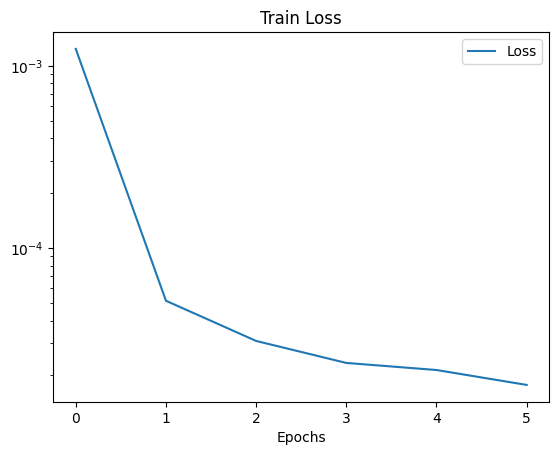

In [ ]:
plt.plot(train_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Train Loss')
plt.show()

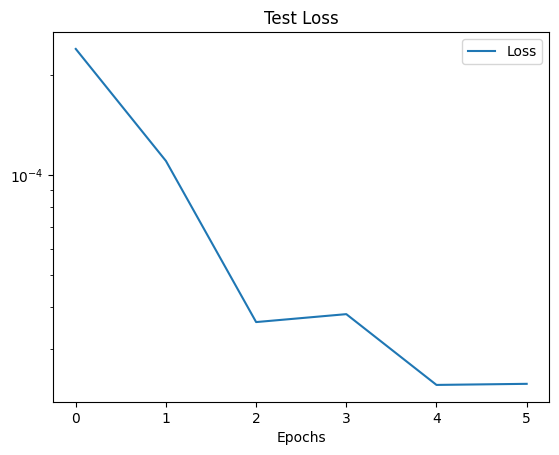

In [ ]:
plt.plot(test_loss, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.legend()
plt.title('Test Loss')
plt.show()

In [ ]:
def create_csv_with_predictions(model,n_cells, device, input_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    pos = []
    loss_fn = nn.MSELoss()
    vrai_pos = []
    norm_acc = []
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, vrai_pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-vrai_pos[-2])[:n_cells]*1e3,pos[-1],vrai_pos[-1])
        if step%1==0:
            norm_acc.append(np.linalg.norm((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[0]))
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
    return loss,norm_acc

In [ ]:
loss,acc = create_csv_with_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_2.csv",200)

tensor([[ 0.1299, -0.0005],
        [-0.0693, -0.0458],
        [-0.0246,  0.0528],
        [-0.1373,  0.1234],
        [ 0.0495,  0.1482],
        [ 0.0952, -0.0299],
        [ 0.0283, -0.1241],
        [-0.0890, -0.1373],
        [ 0.1026, -0.0086],
        [-0.0874,  0.0021]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 0.822702    0.0052639 ]
 [-0.41091021 -0.2586044 ]
 [-0.1472685   0.3361555 ]
 [-0.8693182   0.7509962 ]
 [ 0.2950303   0.8905587 ]
 [ 0.5687514  -0.1768676 ]
 [ 0.1934091  -0.7204028 ]
 [-0.5512413  -0.8074625 ]
 [ 0.6329858  -0.0414471 ]
 [-0.5341403   0.0218101 ]] [[ 0.13449205  0.22188759]
 [ 0.01009518 -0.6416199 ]
 [ 0.632854   -0.63188416]
 [ 0.1662606  -0.15305845]
 [-0.94828624 -0.3643503 ]
 [-0.875452   -0.8333045 ]
 [ 0.9542613   0.95358557]
 [ 0.7458435  -0.89668506]
 [-0.4598045  -0.8154756 ]
 [ 0.7600542   0.12522438]
 [ 0.13449205  2.2218874 ]
 [ 0.01009518  1.35838   ]
 [ 0.632854    1.3681157 ]
 [ 0.1662606   1.8469417 ]
 [-0.94828624  1.6356497 ]


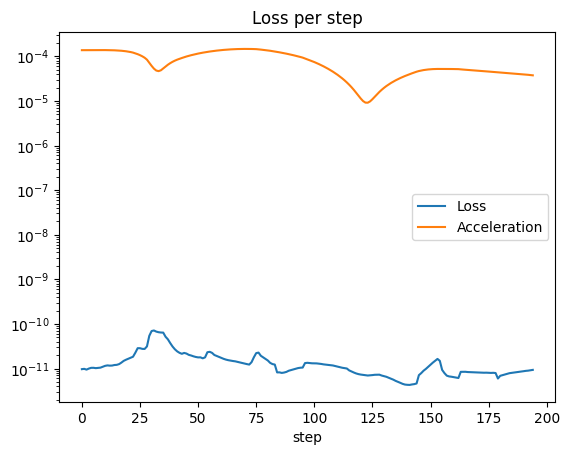

In [ ]:
plt.plot(loss, label='Loss')
plt.plot(acc, label='Acceleration')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()

In [ ]:
def create_csv_with_real_predictions(model,n_cells, device, input_csv, output_csv, steps=200):
    model.eval()
    loss = []
    df = pd.read_csv(input_csv)
    steps_list = df["step"].unique()
    results = []
    pos = []
    vrai_pos = []
    loss_fn = nn.MSELoss()
    for step in steps_list[:5]:
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        pos.append(positions.copy())
        vrai_pos.append(positions.copy())
    for step in steps_list[5:steps]:
        pos,acc = generate_next_positions(model, device, pos,n_cells)
        df_step = df[df["step"] == step]
        positions = df_step[["x", "y"]].to_numpy()
        for i in range(len(vrai_pos)-1):
             vrai_pos[i] = vrai_pos[i+1].copy()
        vrai_pos[-1] = positions.copy()
        print(acc,(vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells]*1e3)
        if step%1==0:
            loss.append(loss_fn(acc/1e3,torch.tensor((vrai_pos[-1]-2*vrai_pos[-2]+vrai_pos[-3])[:n_cells], dtype=torch.float32).to(device)).cpu().detach().numpy())
        for id_, positions in enumerate(pos[-1]):
                results.append({"step": step, "site_index": id_, "x": positions[0], "y": positions[1]})
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    return loss

In [ ]:
loss = create_csv_with_real_predictions(model,10, device, "/home/jeanlienhard/Documents/Cell_GNN/Data/raw_data/positions_1.csv", "/home/jeanlienhard/Documents/Cell_GNN/GNN for acceleration/Supervised/Training/acceleration_15Conv_256/computed_trajectories/computed_positions_1.csv",205)

tensor([[-0.0025, -0.1572],
        [ 0.0221,  0.0576],
        [-0.0105,  0.0534],
        [-0.0714, -0.0648],
        [-0.0797, -0.3219],
        [ 0.0239, -0.0873],
        [ 0.0824,  0.1226],
        [ 0.0902,  0.1344],
        [-0.0031,  0.1570],
        [-0.0653,  0.0925]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 0.0054964  -0.1477537 ]
 [ 0.0245194   0.0594999 ]
 [-0.0140854   0.0531666 ]
 [-0.0713028  -0.0629378 ]
 [-0.06934    -0.3158328 ]
 [ 0.02080098 -0.0845132 ]
 [ 0.0833115   0.12146717]
 [ 0.093753    0.1331907 ]
 [-0.0061131   0.1541623 ]
 [-0.0670398   0.0895506 ]]
tensor([[-0.0039, -0.1587],
        [ 0.0213,  0.0565],
        [-0.0114,  0.0534],
        [-0.0714, -0.0660],
        [-0.0772, -0.3239],
        [ 0.0235, -0.0865],
        [ 0.0800,  0.1241],
        [ 0.0895,  0.1349],
        [-0.0021,  0.1596],
        [-0.0637,  0.0928]], device='cuda:0', grad_fn=<AddmmBackward0>) [[ 0.0065728  -0.1464909 ]
 [ 0.0245782   0.0585137 ]
 [-0.0169271   0.0529463 ]


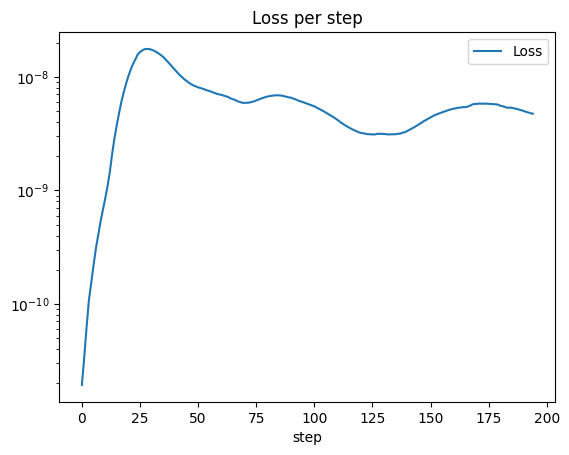

In [ ]:
plt.plot(loss, label='Loss')
plt.yscale('log')
plt.xlabel('step')
plt.legend()
plt.title('Loss per step')
plt.show()